In [1]:
import numpy as np
from typing import List, Dict, Set, Any, Optional, Tuple, Literal, Callable
from time import time

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.metrics import TimeseriesFeatureExtractor

from SWIM_orig import DenseSWIM

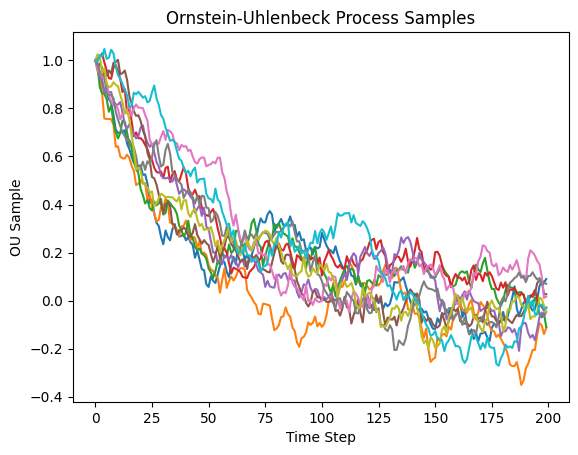

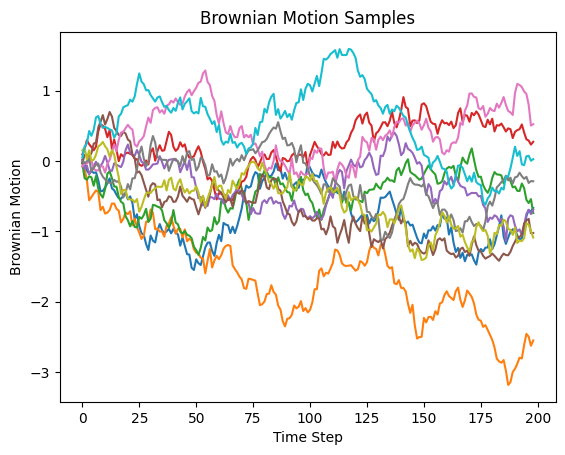

In [2]:
def generate_OU_1d(n_samples, n_steps, dt, theta, mu, sigma, x0):
    """
    Simulate a 1-dimensional Ornstein-Uhlenbeck process using the Milstein method.

    Parameters:
        n_samples (int): Number of samples to generate.
        n_steps (int): Number of time steps to simulate.
        dt (float): Time increment between steps.
        theta (float): Mean reversion rate.
        mu (float): Long-term mean.
        sigma (float): Volatility.
        x0 (float): Initial value.

    Returns:
        numpy.ndarray: Array of shape (n_steps,) with the simulated process.
    """
    # Preallocate array for the process values
    X = np.zeros( (n_samples, n_steps) )
    X[:, 0] = x0

    dW = np.random.randn(n_samples, n_steps-1) * np.sqrt(dt)

    # Generate the 1D OU process using the Milstein method
    for t in range(1, n_steps):
        # Generate standard normal random variable for Wiener process increment

        X[:, t] = X[:, t-1] + theta * (mu - X[:, t-1]) * dt + sigma * dW[:, t-1]

    return X, dW

# Example usage
n_samples = 500  # Number of samples
n_steps = 200  # Number of time steps
dt = 0.01       # Time step size
theta = 2.0     # Mean reversion rate
mu = 0.0        # Long-term mean
sigma = 0.3     # Volatility
x0 = 1.0        # Initial value

# Generate samples
OU_samples, dW = generate_OU_1d(n_samples, n_steps, dt, theta, mu, sigma, x0)
W = np.cumsum(dW, axis=1)

# Plot the OU samples
plt.plot(OU_samples[:10].T)
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Ornstein-Uhlenbeck Process Samples')
plt.show()

plt.plot(W[:10].T)
plt.xlabel('Time Step')
plt.ylabel('Brownian Motion')
plt.title('Brownian Motion Samples')
plt.show()

# ridge regression

Relative L2 error: 0.002869491123759601
Test R^2 score: 0.9998822341368211
Test MAPE: 0.07566513237007651
ridge alpha: 0.03125


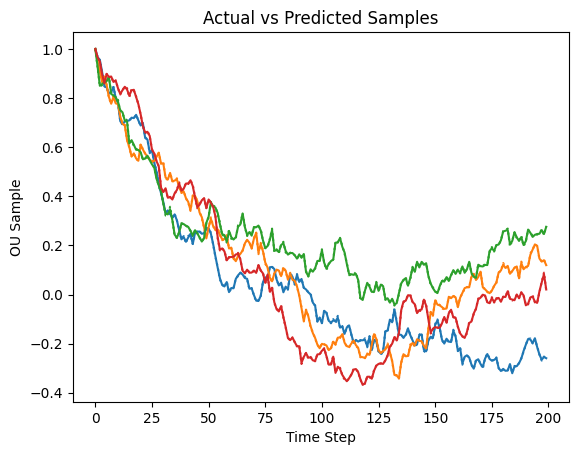

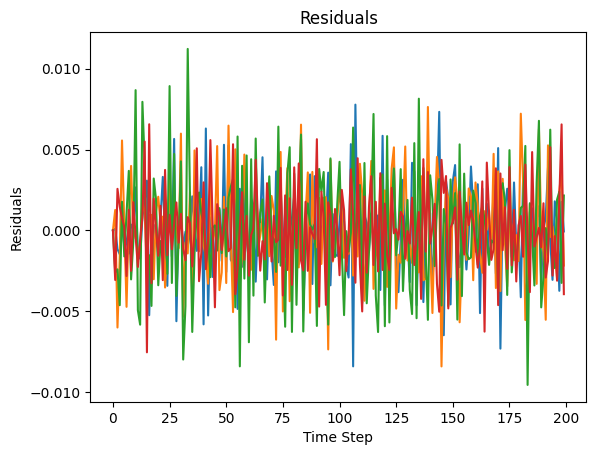

In [3]:
def eval_scores(pred, y):
    # pred and y are shape (n_samples, d)
    rel_l2 = np.linalg.norm(pred-y, ord=2) / np.linalg.norm(y, ord=2)
    r2 = 1 - np.sum((pred-y)**2) / np.sum((y-np.mean(y))**2) #is this correct for multi-dim?
    mape = mean_absolute_percentage_error(y, pred)
    print(f"Relative L2 error: {rel_l2}")
    print(f"Test R^2 score: {r2}")
    print(f"Test MAPE: {mape}")
    return mape

# Create the ridge regression model
ridge_model = RidgeCV(alphas=[2**i for i in range(-5, 2)])
n = len(OU_samples)
train_OU = OU_samples[:n//2]
test_OU = OU_samples[n//2:]
train_W = W[:n//2]
test_W = W[n//2:]


# Fit the model to the data
ridge_model.fit(train_W, train_OU)

# Predict the OU samples using the noise
pred = ridge_model.predict(test_W)
eval_scores(pred, test_OU)
print("ridge alpha:", ridge_model.alpha_)

# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

# DenseSWIM

Relative L2 error: 0.09579670125492362
Test R^2 score: 0.9258980570755313
Test MAPE: 2.412728982546573
alpha: 0.03125


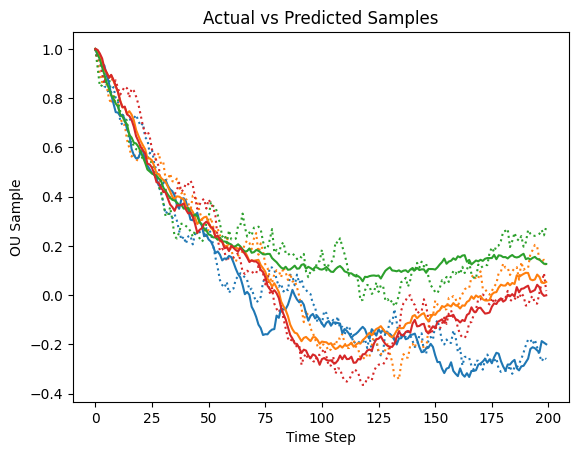

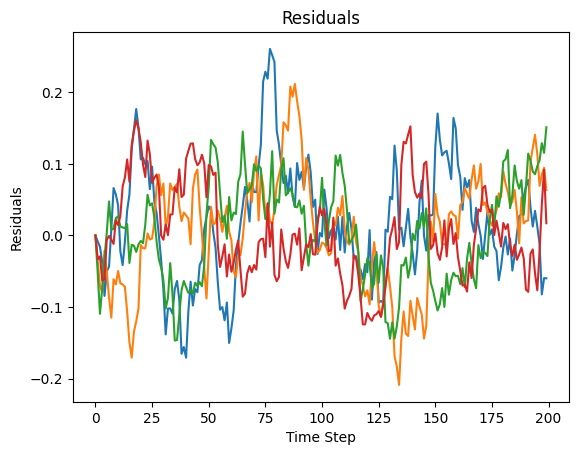

In [27]:
###### Test dense layer ######

def train_sampling(x_train, y_train, n_layers, n_width, random_seed=3, SWIM=DenseSWIM):
    steps = []
    for k_layer in range(n_layers):
        steps.append((f"fcn{k_layer+1}", SWIM(layer_width=n_width, 
                                                   activation="tanh", 
                                                   parameter_sampler='tanh', 
                                                   random_seed=1 + random_seed + k_layer * 1234)))
    steps.append(("ridgeCV", RidgeCV(alphas=[2**i for i in range(-5, 2)])))
    model = Pipeline(steps=steps, verbose=False)
    t0 = time()
    model.fit(x_train, y_train)
    t_fit = time()
    return model, t_fit-t0


n_layers = 3
n_width = 100

model, time_fit = train_sampling(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU)
pred = model.predict(test_W)
eval_scores(pred, test_OU)
print("alpha:", model.named_steps['ridgeCV'].alpha_)

# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

# SWIM residual

Relative L2 error: 0.04591321405936632
Test R^2 score: 0.9706529568931166
Test MAPE: 1.1607600714483712
alpha: 0.03125


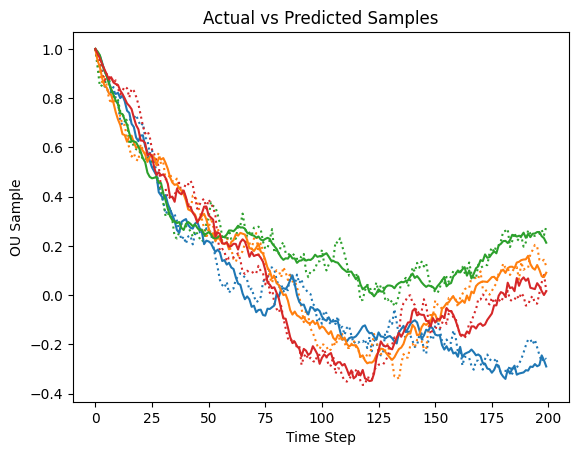

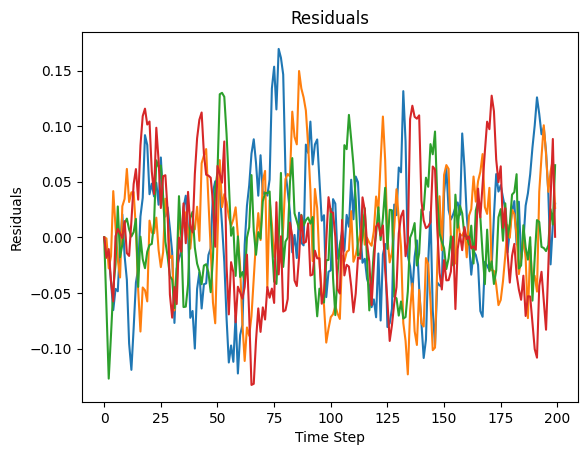

In [28]:
###### Test dense layer ######
from SWIM_residual_mlp import DenseResSWIM

model, time_fit = train_sampling(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU, SWIM=DenseResSWIM)
pred = model.predict(test_W)
eval_scores(pred, test_OU)
print("alpha:", model.named_steps['ridgeCV'].alpha_)

# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

# Random feature network

Best alpha: 0.01
Relative L2 error: 0.05190098649183867
Test R^2 score: 0.9632416007060242
Test MAPE: 1.6476901876585692


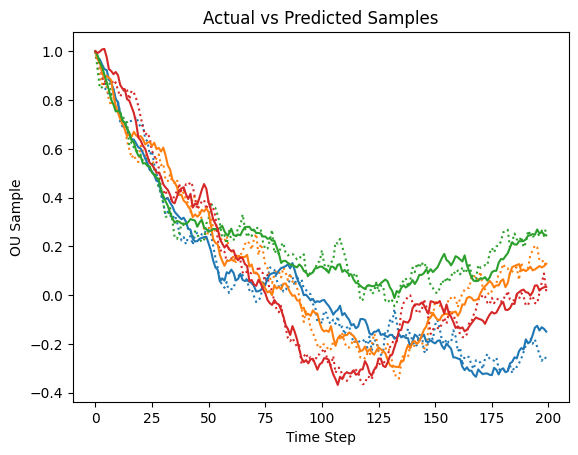

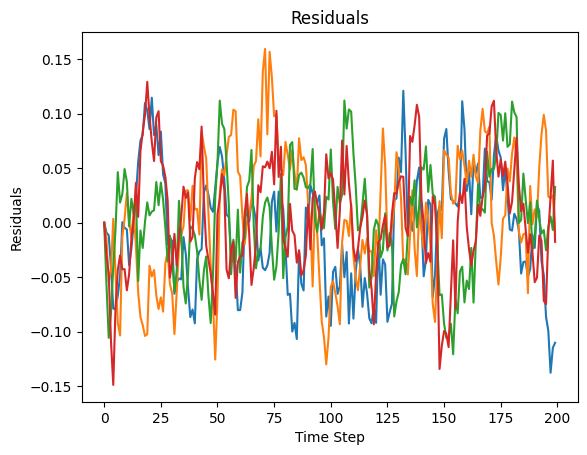

In [29]:
import torch
import torch.nn as nn
import torchvision as tv

class random_MLP():
    def __init__(self, in_channels, n_layers, n_width, alphas = [0.01, 0.1, 1, 10]):
        self.mlp = tv.ops.MLP(
            in_channels=in_channels,
            hidden_channels=[n_width]*n_layers,
            bias=True,
            )
        
        self.ridge = RidgeCV(alphas=alphas)
    

    def fit(self, x, y):
        x = torch.from_numpy(x).float()
        x = self.mlp(x).detach().numpy()
        self.ridge.fit(x, y)
        print("Best alpha:", self.ridge.alpha_)

    def predict(self, x):
        x = torch.from_numpy(x).float()
        x = self.mlp(x).detach().numpy()
        return self.ridge.predict(x)
    

model = random_MLP(
    in_channels=n_steps-1,
    n_layers=n_layers,
    n_width=n_width,
    )
model.fit(train_W, train_OU)

# Predict the OU samples using the noise
pred = model.predict(test_W)
eval_scores(pred, test_OU)

# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

# TEST JAX MODEL TO SEE IF WE GET SIMILAR RESULTS

In [30]:
from typing import Tuple, List, Union, Any, Optional, Dict, Set, Literal, Callable
import os
import sys
from functools import partial
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

import numpy as np
import jax
import jax.numpy as jnp
import jax.lax as lax
from jaxtyping import Array, Float, Int, PRNGKeyArray
from jax.random import PRNGKey
import aeon
import pandas as pd

from features.sig_trp import SigVanillaTensorizedRandProj, SigRBFTensorizedRandProj
from features.sig import SigTransform, LogSigTransform
from features.base import TimeseriesFeatureTransformer, TabularTimeseriesFeatures, RandomGuesser
from features.sig_neural import RandomizedSignature
from utils.utils import print_name, print_shape
from preprocessing.timeseries_augmentation import normalize_mean_std_traindata, normalize_streams, augment_time, add_basepoint_zero

jax.config.update('jax_platform_name', 'cpu') # Used to set the platform (cpu, gpu, etc.)
np.set_printoptions(precision=3, threshold=5) # Print options

Relative L2 error: 0.08809011870626045
Test R^2 score: 0.9327154206238684
Test MAPE: 2.2944683305706013
alpha: 0.5


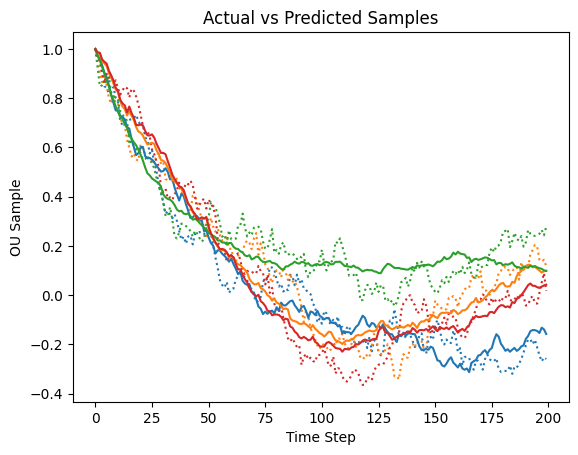

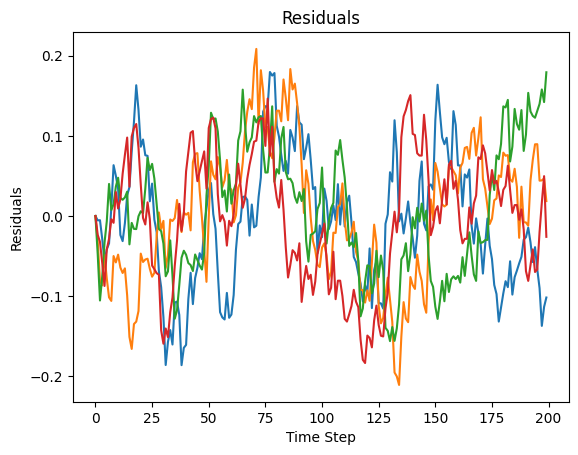

In [31]:
###### Test jax dense layer ######
from features.SWIM_mlp import SWIM_MLP

def train_sampling_JAX(x_train, y_train, n_layers, n_width, seed=PRNGKey(2), add_residual=False):
    swim_model = SWIM_MLP(seed, n_width, n_layers, add_residual)
    ridge = RidgeCV(alphas=[2**i for i in range(-5, 2)])

    swim_model.fit(x_train, y_train)
    ridge.fit(np.array(swim_model.transform(x_train)), y_train)

    return swim_model, ridge

model, ridge = train_sampling_JAX(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU)
pred = ridge.predict(np.array(model.transform(test_W)))
eval_scores(pred, test_OU)
print("alpha:", ridge.alpha_)

# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

Relative L2 error: 0.050674121287676906
Test R^2 score: 0.9632613851394161
Test MAPE: 1.4717856283866881
alpha: 0.25


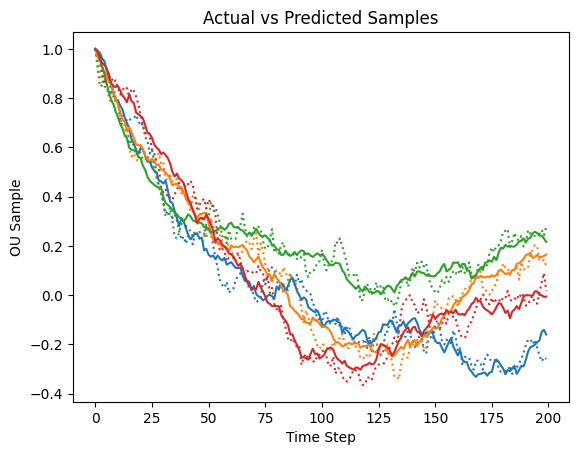

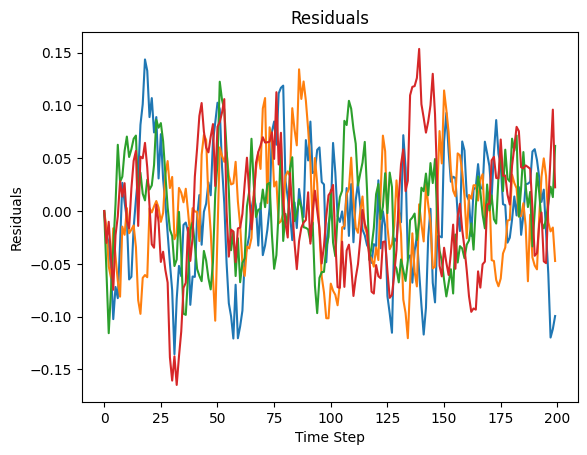

In [32]:
###### Test jax residual ######
from features.SWIM_mlp import SWIM_MLP

swim_model, ridge = train_sampling_JAX(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU, add_residual=True)
pred = ridge.predict(np.array(swim_model.transform(test_W)))
eval_scores(pred, test_OU)
print("alpha:", ridge.alpha_)

# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

Relative L2 error: 0.03305137285636304
Test R^2 score: 0.9754202820917556
Test MAPE: 1.0787911377528685
Relative L2 error: 0.03305137285636304
Test R^2 score: 0.9754202820917556
Test MAPE: 1.0787911377528685
Best alpha: 0.1
Relative L2 error: 0.01420156166114425
Test R^2 score: 0.9940223904005625
Test MAPE: 0.5381644855872536
Relative L2 error: 0.03630633632282803
Test R^2 score: 0.9744666539040692
Test MAPE: 1.1334240077644457
Relative L2 error: 0.03857364141157366
Test R^2 score: 0.9722642376062021
Test MAPE: 1.1725203941161275
Relative L2 error: 0.07543024882985996
Test R^2 score: 0.9429967677569396
Test MAPE: 1.8907057535469383
Relative L2 error: 0.036844149970299375
Test R^2 score: 0.9732451391122369
Test MAPE: 1.120360984316815
Best alpha: 0.01
Relative L2 error: 0.03520978500208491
Test R^2 score: 0.9761534981156467
Test MAPE: 1.185716878484526
Relative L2 error: 0.06362313067917609
Test R^2 score: 0.949543272624267
Test MAPE: 1.747108375098246
Relative L2 error: 0.0413894236758

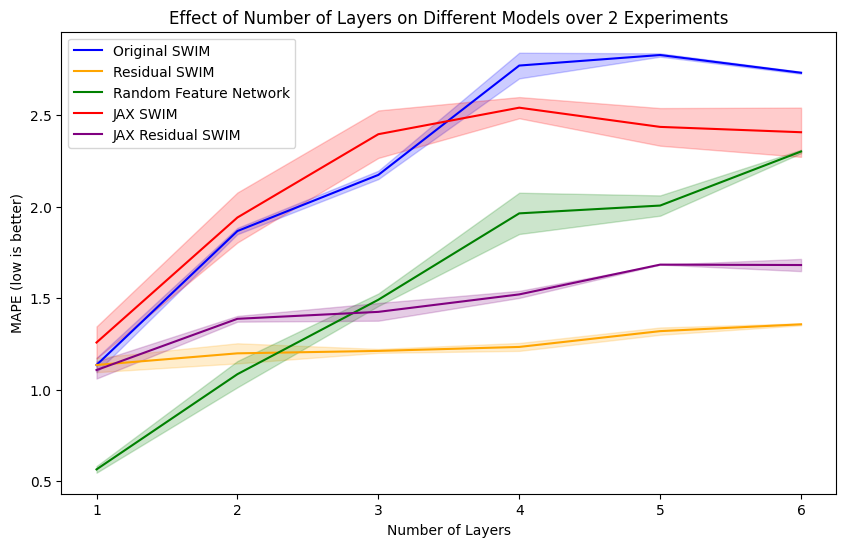

In [33]:

def experiment_with_layers(num_layers=[1,2,3,4,5,6], n_experiment=5):

    # Initialize arrays to store the evaluation scores for each model across multiple experiments
    original_swim_scores = np.zeros((len(num_layers), n_experiment))
    residual_swim_scores = np.zeros((len(num_layers), n_experiment))
    random_feature_scores = np.zeros((len(num_layers), n_experiment))
    jax_swim_scores = np.zeros((len(num_layers), n_experiment))
    jax_residual_swim_scores = np.zeros((len(num_layers), n_experiment))

    # Run experiments
    for i_exp in range(n_experiment):
        for idx, n_layers in enumerate(num_layers):
            # Evaluate the original SWIM model
            model, _ = train_sampling(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU, random_seed=i_exp)
            pred = model.predict(test_W)
            original_swim_scores[idx, i_exp] = eval_scores(pred, test_OU)

            # Evaluate the residual SWIM model
            model, _ = train_sampling(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU, SWIM=DenseResSWIM, random_seed=i_exp)
            pred = model.predict(test_W)
            residual_swim_scores[idx, i_exp] = eval_scores(pred, test_OU)

            # Evaluate the random feature network model
            model = random_MLP(in_channels=n_steps-1, n_layers=n_layers, n_width=n_width)
            model.fit(train_W, train_OU)
            pred = model.predict(test_W)
            random_feature_scores[idx, i_exp] = eval_scores(pred, test_OU)

            # Evaluate the JAX SWIM model
            swim_model, ridge = train_sampling_JAX(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU, seed=PRNGKey(i_exp+10000))
            pred = ridge.predict(np.array(swim_model.transform(test_W)))
            jax_swim_scores[idx, i_exp] = eval_scores(pred, test_OU)

            # Evaluate the JAX residual SWIM model
            swim_model, ridge = train_sampling_JAX(n_layers=n_layers, n_width=n_width, x_train=train_W, y_train=train_OU, add_residual=True, seed=PRNGKey(i_exp+20000))
            pred = ridge.predict(np.array(swim_model.transform(test_W)))
            jax_residual_swim_scores[idx, i_exp] = eval_scores(pred, test_OU)

    # Compute means and standard errors
    def compute_mean_and_stderr(scores):
        mean_scores = np.mean(scores, axis=1)
        stderr_scores = np.std(scores, axis=1) / np.sqrt(n_experiment)
        return mean_scores, stderr_scores

    original_mean, original_stderr = compute_mean_and_stderr(original_swim_scores)
    residual_mean, residual_stderr = compute_mean_and_stderr(residual_swim_scores)
    random_mean, random_stderr = compute_mean_and_stderr(random_feature_scores)
    jax_swim_mean, jax_swim_stderr = compute_mean_and_stderr(jax_swim_scores)
    jax_residual_mean, jax_residual_stderr = compute_mean_and_stderr(jax_residual_swim_scores)

    # Plot the results with error bars (shaded regions)
    plt.figure(figsize=(10, 6))
    plt.plot(num_layers, original_mean, label='Original SWIM', color='blue')
    plt.fill_between(num_layers, original_mean - original_stderr, original_mean + original_stderr, color='blue', alpha=0.2)

    plt.plot(num_layers, residual_mean, label='Residual SWIM', color='orange')
    plt.fill_between(num_layers, residual_mean - residual_stderr, residual_mean + residual_stderr, color='orange', alpha=0.2)

    plt.plot(num_layers, random_mean, label='Random Feature Network', color='green')
    plt.fill_between(num_layers, random_mean - random_stderr, random_mean + random_stderr, color='green', alpha=0.2)

    plt.plot(num_layers, jax_swim_mean, label='JAX SWIM', color='red')
    plt.fill_between(num_layers, jax_swim_mean - jax_swim_stderr, jax_swim_mean + jax_swim_stderr, color='red', alpha=0.2)

    plt.plot(num_layers, jax_residual_mean, label='JAX Residual SWIM', color='purple')
    plt.fill_between(num_layers, jax_residual_mean - jax_residual_stderr, jax_residual_mean + jax_residual_stderr, color='purple', alpha=0.2)

    plt.xlabel('Number of Layers')
    plt.ylabel('MAPE (low is better)')
    plt.title(f'Effect of Number of Layers on Different Models over {n_experiment} Experiments')
    plt.legend()
    plt.show()

experiment_with_layers(num_layers=[1,2,3,4,5,6], n_experiment=2)

Relative L2 error: 0.0597163641899239
Test R^2 score: 0.9562964020377172
Test MAPE: 1.8341921539779287
Relative L2 error: 0.0597163641899239
Test R^2 score: 0.9562964020377172
Test MAPE: 1.8341921539779287
Best alpha: 0.1
Relative L2 error: 0.058713014170704826
Test R^2 score: 0.9680088074638687
Test MAPE: 1.1715197887245998
Relative L2 error: 0.07761544933035984
Test R^2 score: 0.9481728250558266
Test MAPE: 1.922504311068733
Relative L2 error: 0.07761544933035984
Test R^2 score: 0.9481728250558266
Test MAPE: 1.922504311068733
Relative L2 error: 0.047647652944006164
Test R^2 score: 0.9652555666849953
Test MAPE: 1.3945796787366092
Relative L2 error: 0.047647652944006164
Test R^2 score: 0.9652555666849953
Test MAPE: 1.3945796787366092
Best alpha: 0.1
Relative L2 error: 0.035692321986851974
Test R^2 score: 0.9823790885572691
Test MAPE: 1.045623960925203
Relative L2 error: 0.05426657213981727
Test R^2 score: 0.9617197805319971
Test MAPE: 1.608342001697489
Relative L2 error: 0.0542665721398

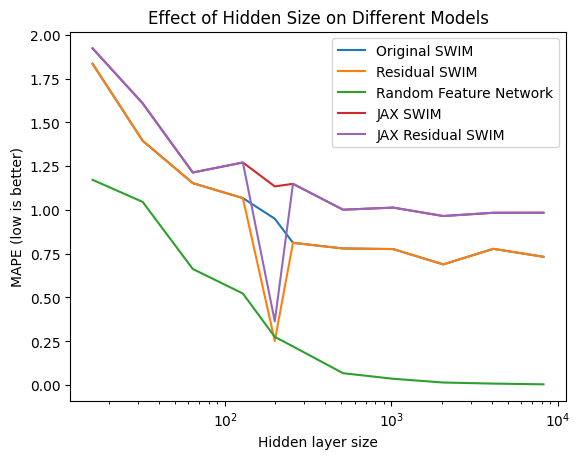

In [34]:
def plot_vs_hiddensize(hidden_sizes, num_layers):
    # Initialize lists to store the evaluation scores for each model
    original_swim_scores = []
    residual_swim_scores = []
    random_feature_scores = []
    jax_swim_scores = []
    jax_residual_swim_scores = []

    # Evaluate the models for each number of layers
    for h in hidden_sizes:
        # Evaluate the original SWIM model
        model, _ = train_sampling(n_layers=num_layers, n_width=h, x_train=train_W, y_train=train_OU)
        pred = model.predict(test_W)
        original_swim_scores.append(eval_scores(pred, test_OU))
        
        # Evaluate the residual SWIM model
        model, _ = train_sampling(n_layers=num_layers, n_width=h, x_train=train_W, y_train=train_OU, SWIM=DenseResSWIM)
        pred = model.predict(test_W)
        residual_swim_scores.append(eval_scores(pred, test_OU))
        
        # Evaluate the random feature network model
        model = random_MLP(in_channels=n_steps-1, n_layers=num_layers, n_width=h)
        model.fit(train_W, train_OU)
        pred = model.predict(test_W)
        random_feature_scores.append(eval_scores(pred, test_OU))
        
        # Evaluate the JAX SWIM model
        swim_model, ridge = train_sampling_JAX(n_layers=num_layers, n_width=h, x_train=train_W, y_train=train_OU)
        pred = ridge.predict(np.array(swim_model.transform(test_W)))
        jax_swim_scores.append(eval_scores(pred, test_OU))
        
        # Evaluate the JAX residual SWIM model
        swim_model, ridge = train_sampling_JAX(n_layers=num_layers, n_width=h, x_train=train_W, y_train=train_OU, add_residual=True)
        pred = ridge.predict(np.array(swim_model.transform(test_W)))
        jax_residual_swim_scores.append(eval_scores(pred, test_OU))

    # Plot the evaluation scores for each model
    plt.semilogx(hidden_sizes, original_swim_scores, label='Original SWIM')
    plt.semilogx(hidden_sizes, residual_swim_scores, label='Residual SWIM')
    plt.semilogx(hidden_sizes, random_feature_scores, label='Random Feature Network')
    plt.semilogx(hidden_sizes, jax_swim_scores, label='JAX SWIM')
    plt.semilogx(hidden_sizes, jax_residual_swim_scores, label='JAX Residual SWIM')
    plt.xlabel('Hidden layer size')
    plt.ylabel('MAPE (low is better)')
    plt.title('Effect of Hidden Size on Different Models')
    plt.legend()
    plt.show()

plot_vs_hiddensize([16, 32, 64, 128, 199, 256, 512, 1024, 2048, 4096, 8192], 1)

# sampled Controlled ResNet

Relative L2 error: 0.08161783702672114
Test R^2 score: 0.9469655974991332
Test MAPE: 1.3074213371196888
alpha: 2.0


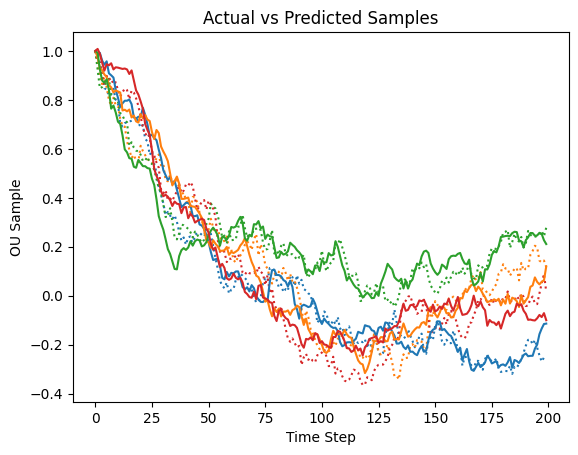

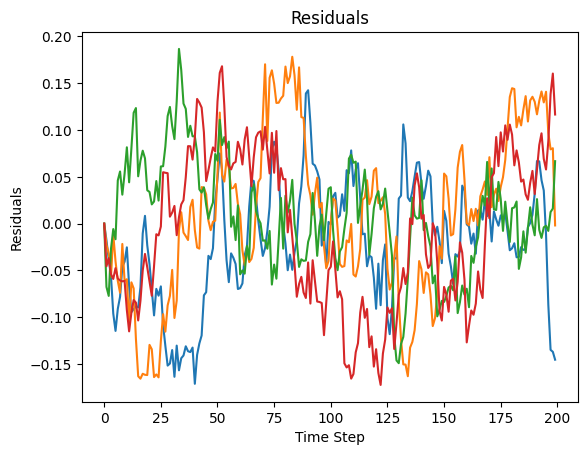

In [35]:
from features.SWIM_controlled_resnet import SampledControlledResNet

def train_sampling_CRN(x_train, y_train, n_width, seed=PRNGKey(2)):
    feat_model = SampledControlledResNet(
        seed, 
        n_width, 
        activation= jnp.tanh #lambda x : jnp.maximum(0, x+0.5)
        )
    ridge = RidgeCV(alphas=[2**i for i in range(-5, 2)])
    x_train = x_train[..., None]
    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train)

    feat_model.fit(x_train, y_train)
    ridge.fit(np.array(feat_model.transform(x_train)), y_train)

    return feat_model, ridge

swim_model, ridge = train_sampling_CRN(train_W, train_OU, n_width)
pred = ridge.predict(np.array(swim_model.transform(jnp.array(test_W[..., None]))))
eval_scores(pred, test_OU)
print("alpha:", ridge.alpha_)

# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()


# randomized sig

Relative L2 error: 0.1360407595401218
Test R^2 score: 0.8950733312066941
Test MAPE: 2.754592289614069
alpha: 2.0


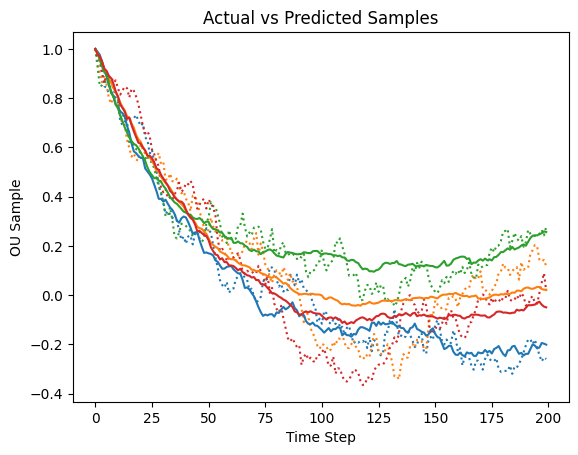

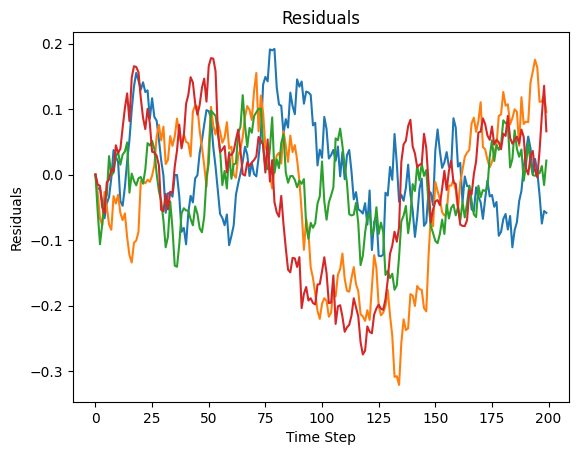

In [36]:
from features.sig_neural import RandomizedSignature

def train_randsig(x_train, y_train, n_width, seed=PRNGKey(2), RandSig = RandomizedSignature):
    feat_model = RandSig(
        seed, 
        n_width,
        )
    ridge = RidgeCV(alphas=[2**i for i in range(-5, 2)])
    x_train = x_train[..., None]
    x_train = jnp.array(x_train)
    y_train = jnp.array(y_train)

    feat_model.fit(x_train, y_train)
    ridge.fit(np.array(feat_model.transform(x_train)), y_train)

    return feat_model, ridge

swim_model, ridge = train_randsig(train_W, train_OU, n_width)
pred = ridge.predict(np.array(swim_model.transform(jnp.array(test_W[..., None]))))
eval_scores(pred, test_OU)
print("alpha:", ridge.alpha_)

# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

Relative L2 error: 0.27419623561722084
Test R^2 score: 0.7393060001591667
Test MAPE: 3.9978608980665875
alpha: 2.0


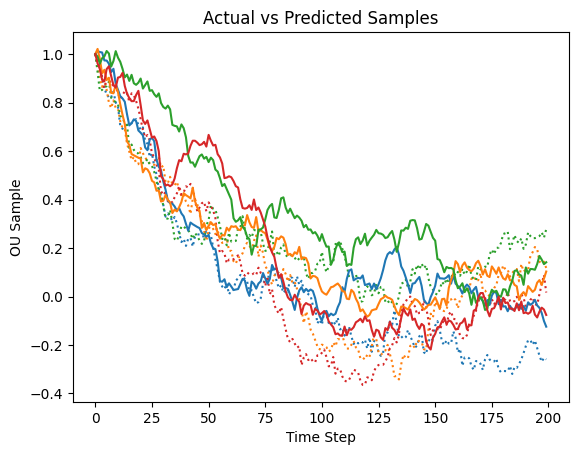

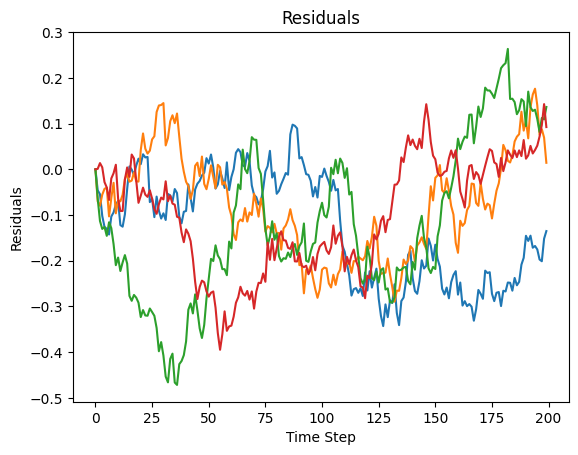

In [37]:
from features.sig_neural import TimeInhomogenousRandomizedSignature

swim_model, ridge = train_randsig(train_W, train_OU, n_width, RandSig=TimeInhomogenousRandomizedSignature)
pred = ridge.predict(np.array(swim_model.transform(jnp.array(test_W[..., None]))))
eval_scores(pred, test_OU)
print("alpha:", ridge.alpha_)

# Plot the fit
plt.plot(test_OU[:4].T, label='Actual Samples', linestyle='dotted')
plt.gca().set_prop_cycle(None)
plt.plot(pred[:4].T, label='Predicted Samples')
plt.xlabel('Time Step')
plt.ylabel('OU Sample')
plt.title('Actual vs Predicted Samples')
plt.show()

#residuals
plt.plot(test_OU[:4].T-pred[:4].T)
plt.xlabel('Time Step')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()